Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
tf.set_random_seed(2)
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/xai/xai-genz/venv/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
import os
import keras
from keras.preprocessing import image
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.3.1


# LOAD KERAS PRETRAINED MODEL

In [3]:
from keras.models import load_model

model = load_model('finetune.model')
model.load_weights('weights.best.hdf5')

print(model.summary())




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_________________________________________________________________________________________

# LOAD AND PREPROCESS IMAGE

In [4]:
def preprocess_input_inceptionv3(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def load_image(path): 
  img = Image.open(path)
  img = np.array(img)
  x = img_to_array(img)
  x = preprocess_input_inceptionv3(x)

  return x

In [5]:
class_names = {
    0: '1886 - Accessories', 
    1: '1887 - Swimwear', 
    2: '1888 - One piece',
    3: '1889 - Upper part', 
    4: '1890 - Shoes', 
    5: '1891 - Bottom part', 
    6: '1892 - Underwear'
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


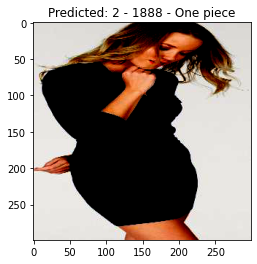

In [7]:
from PIL import Image, ImageDraw
from keras_preprocessing.image import img_to_array

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

x = load_image('images/1888/c29977b941a2168c312319e55907028a3dc1fb45.jpg')
y_pred = model.predict(x.reshape(1,299,299,3))
class_idx = np.argmax(y_pred)

plt.figure()
plt.title(f'Predicted: {class_idx} - {class_names[int(class_idx)]}')
plt.imshow(x)
plt.grid(False)
plt.show()

## Explanation

In [8]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [9]:
explainer = lime_image.LimeImageExplainer()

In [10]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
#explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)
explanation = explainer.explain_instance(x, model.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 17.7 s, sys: 260 ms, total: 17.9 s
Wall time: 17 s


### Now let's see the explanation for the top class ( Black Bear)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

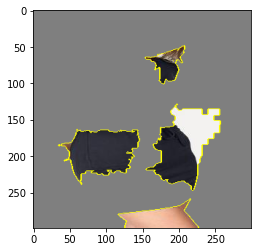

In [11]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

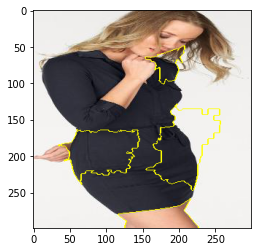

In [12]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

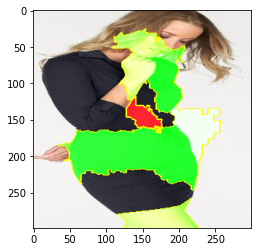

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

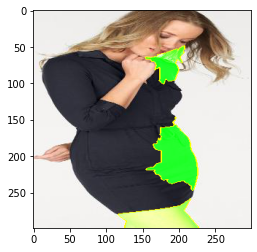

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Let's see the explanation for the second highest prediction

Most positive towards wombat:

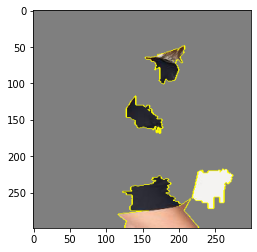

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

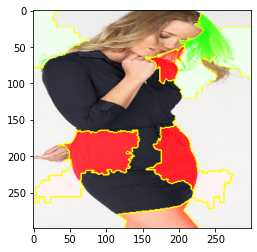

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
